$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# TeslaMax

Teslamax model:

![Teslamax Model](img/teslamax.png)

Tell the location of the TeslaMax Java class file:

In [1]:
from pathlib import Path
import os
import subprocess
import math
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from scipy.interpolate import  NearestNDInterpolator, LinearNDInterpolator, CloughTocher2DInterpolator,griddata



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)


In [2]:
SAVE_FIG_Q = False
FIGURES_DIR_NAME = "figures"
FIG_FILE_PATH = Path('.')

FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM/2.54

FONTSIZE = 18


FIGSIZE_CM_SMALL = 8
FIGSIZE_INCHES_SMALL = FIGSIZE_CM_SMALL/2.54
FONTSIZE_SMALL = 12

MARKERSIZE = 8.0

PLOT_EXTENSION = '.png'

DPI = 650

In [3]:
comsol_class_file = Path.home() / 'code' / 'teslamax' / 'java' / 'TeslaMax.class'
print(comsol_class_file)
print("Does the above file exist: %s" %(str(comsol_class_file.exists())))

C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
Does the above file exist: True


Command to execute the COMSOL Java class file:

In [4]:
comsol_cmd = ['comsolbatch', '-inputfile', str(comsol_class_file)]

These are some the key files that are processed during the COMSOL simulation:

In [5]:
B_HIGH_FILENAME = "B_high.txt"
B_LOW_FILENAME = "B_low.txt"

H_IV_FILENAME = "H_IV_1Q.txt"

MAIN_RESULTS_FILENAME = "COMSOL Main Results.txt"

MAGNETIC_PROFILE_FILENAME = "COMSOL Magnetic Profile.txt"

COMSOL_PARAMETER_FILENAME = "params.txt"

TESLAMAX_RESULTS_FILENAME = "TeslaMax Main Results.txt"
TESLAMAX_RESULTS_RANDOM_FILENAME = "TeslaMax Main Results (Random).txt"

Other constants:

In [6]:
N_PROFILE_POINTS = 100

N_POINTS_PER_AXIS = 400

Some auxiliary functions to process the results:

In [7]:
def get_comsol_parameters_series():
    """Parse the COMSOL parameters file in the current directory and
    return a pandas Series from it.
    
    """
    param_comsol_file = Path('.') / COMSOL_PARAMETER_FILENAME

    param_comsol_series = pd.read_table(str(param_comsol_file),
                                        squeeze=True,
                                        sep=" ",
                                        index_col=0,
                                        header=None)

    param_comsol_series.name = "COMSOL Parameters"
    param_comsol_series.index.name = None
    
    # append the units to the parameters names
    names_with_units = {}
    for name in param_comsol_series.keys():
        if name.startswith("h_") or name.startswith("R_"):
            names_with_units[name] = name+"[m]"
        if name.startswith("alpha") or name.startswith("phi") or name.startswith("delta_phi"):
            names_with_units[name] = name + "[deg]"
        if name.startswith("B_"):
            names_with_units[name] = name + "[T]"
        if name.startswith("H_c"):
            names_with_units[name] = name + "[A/m]"

    param_comsol_series = param_comsol_series.rename(names_with_units)
    return param_comsol_series

In [8]:
def read_comsol_data_file(filename):
    """Read and parse 'filename' as exported by COMSOL.
    Export the numerical data as a numpy array containing only the numerical
    data; the first two columns are x and y values. All values are in SI.
    
    Keyword Arguments:
    filename -- str
    """

    return np.loadtxt(filename,skiprows=9)

In [9]:
def process_main_results_file():
    """Take the file "COMSOL Main Results.txt" as exported by COMSOL and
    clean the header data.
    
    """
    
    p = Path('.') / MAIN_RESULTS_FILENAME

    param_comsol_series = get_comsol_parameters_series()

    results = pd.read_table(MAIN_RESULTS_FILENAME,
                            sep="\s+",
                            skiprows=5,
                            index_col=None,
                            header=None,
                            names=["B_high[T]",
                                   "B_low[T]",
                                   "A_gap[m2]",
                                   "A_magnet[m2]",
                                   "-H_Brem_II_max[A/m]",
                                   "-H_Brem_IV_max[A/m]"])
    
    results_series = results.ix[0]
       
    results_series.to_csv(str(p),
                       float_format="%.6f",
                       sep=" ",
                       index=True)

In [10]:
def read_main_results_file():
    """Return a Series where each row is one of the COMSOL Main results"""
    
    results_filepath = Path(MAIN_RESULTS_FILENAME)

    results_series = pd.read_table(results_filepath,
                              sep=" ",
                              squeeze=True,
                              index_col=0,
                              header=None)
    results_series.index.name=None
    results_series.name = "COMSOL Main Results"
    return results_series

In [11]:
def write_magnetic_profile_file():
    """Create a file "COMSOL Magnetic Profile.txt" in the current directory,
    assuming the teslamax command was already ran, and write the magnetic
    profile data (average magnetic induction over radial chords).
    
    """
    
    p = Path('.') / MAGNETIC_PROFILE_FILENAME
    column_names = ["phi[deg]","B[T]"]
    column_header = " ".join(column_names)
    
    # load data from the high and low field regions
    B_h = read_comsol_data_file(B_HIGH_FILENAME)
    B_l = read_comsol_data_file(B_LOW_FILENAME)
    
    B_1q = np.concatenate((B_h,B_l),axis=0)
    
    # calcualte vector of angles for the first quadrant
    case_series = get_comsol_parameters_series()
    
    n_phi_points = 200
    
    R_g = case_series['R_g[m]']
    R_o = case_series['R_o[m]']
    
    
    # create ranges for phi and r
    phi_min = 0.0
    phi_max = np.pi/2
    
    phi_vector_1q = np.linspace(phi_min,phi_max,N_PROFILE_POINTS)
    
    # slightly offset the boundaries to avoid numerical problems at the interfaces
    r_min = 1.001*R_o 
    r_max = 0.999*R_g
    n_r_points = 5
    
    r_vector = np.linspace(r_min,r_max,n_r_points)
    
    r_grid, phi_grid = np.meshgrid(r_vector,phi_vector_1q)
    
    # calcualte the points (x,y) distributed along
    # radial lines
    x_grid = r_grid * np.cos(phi_grid)
    y_grid = r_grid * np.sin(phi_grid)
    
    # create a interpolation function over the 1st quadrant grid
    # we use the nearest interpolation to avoid negative values
    # when fitting a spline near points where B = 0
    
    #fB = NearestNDInterpolator(x=B_1q[:,0:2],y=B_1q[:,2])
    fB = CloughTocher2DInterpolator(B_1q[:,0:2],B_1q[:,2])

    # because both x_grid and y_grid have shape (n_r_points, N_PROFILE_POINTS),
    # when we apply the above created function we will get an array with the
    # same shape. We then take the average value along each row,
    # resuting in an array (N_PROFILE_POINTS)
    B_profile_1q = np.mean(fB(x_grid,y_grid),axis=1)

    # extrapolate data to the full circle
    phi_vector = np.concatenate((phi_vector_1q,
                                 phi_vector_1q+np.pi/2,
                                 phi_vector_1q+np.pi,
                                 phi_vector_1q+(3/2)*np.pi))

    B_profile = np.concatenate((B_profile_1q,
                                B_profile_1q[::-1],
                                B_profile_1q,
                                B_profile_1q[::-1]))

    profile_data = np.array((np.rad2deg(phi_vector),B_profile)).T
    
    np.savetxt(str(p),
               profile_data,
               fmt=("%.2f","%.5f"),
               delimiter=" ",
               header=column_header,
               comments='')
    

In [12]:
def write_magnetic_profile_central_file():
    """Create a file "COMSOL Magnetic Profile.txt" in the current directory,
    assuming the teslamax command was already ran, and write the magnetic
    profile data (magnetic induction at central radial position).
    
    """
    
    p = Path('.') / MAGNETIC_PROFILE_FILENAME
    column_names = ["phi[deg]","B[T]"]
    column_header = " ".join(column_names)
    
    # load data from the high and low field regions
    B_h = read_comsol_data_file(B_HIGH_FILENAME)
    B_l = read_comsol_data_file(B_LOW_FILENAME)
    
    B_1q = np.concatenate((B_h,B_l),axis=0)
    
    # calcualte vector of angles for the first quadrant
    case_series = get_comsol_parameters_series()
    
    n_phi_points = 100
    
    R_g = case_series['R_g[m]']
    R_o = case_series['R_o[m]']
    
    
    # create ranges for phi and r
    phi_min = 0.0
    phi_max = np.pi/2
    
    phi_vector_1q = np.linspace(phi_min,phi_max,N_PROFILE_POINTS)
    
    r_min = R_o 
    r_max = R_g
    
    r_central = .5*(R_o + R_g)

    
    # calcualte the points (x,y) distributed along
    # radial lines
    x_grid = r_central * np.cos(phi_vector_1q)
    y_grid = r_central * np.sin(phi_vector_1q)

    B_profile_1q = griddata(B_1q[:,0:2],B_1q[:,2],np.array([x_grid,y_grid]).T)

    # extrapolate data to the full circle
    phi_vector = np.concatenate((phi_vector_1q,
                                 phi_vector_1q+np.pi/2,
                                 phi_vector_1q+np.pi,
                                 phi_vector_1q+(3/2)*np.pi))

    B_profile = np.concatenate((B_profile_1q,
                                B_profile_1q[::-1],
                                B_profile_1q,
                                B_profile_1q[::-1]))

    profile_data = np.array((np.rad2deg(phi_vector),B_profile)).T
    
    np.savetxt(str(p),
               profile_data,
               fmt=("%.2f","%.5f"),
               delimiter=" ",
               header=column_header,
               comments='')
    

In [13]:
def run_teslamax(verbose=False):
    """Run the teslamax process in the current directory, clean the results file 
    and create a magnetic profile file.
    
    Assumes the parameters file is present in the current directory."""
    comsol_process = subprocess.run(comsol_cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT,universal_newlines=True)
    if verbose: print(comsol_process.stdout)
    process_main_results_file()
    write_magnetic_profile_file()
    #write_magnetic_profile_central_file()

In [14]:
def remove_units_from_dict_keys(dictionary):
    """Remove a string '[<anything>]' from every key of 'dictionary'"""
    
    new_dictionary = {}
    
    for key in dictionary.keys():
        new_key = key.split('[')[0]
        new_dictionary[new_key] = dictionary[key]
        
    return new_dictionary

In [24]:
def write_parameter_file_from_dict(param_dict):
    """From a basic 'param_dict', calculate the necessary other parameters 
    (e.g. magnet segment size from total size and number of segments) and write 
    the correct parameters file.
    
    If 'param_dict' contains units in the names, they are removed.
    """
    
    param_dict = remove_units_from_dict_keys(param_dict)
    
    # cast the number of segments to int, if necessary
    param_dict["n_IV"] = int(param_dict["n_IV"])
    
    # remove some keys that are not necessary (and which may cause errors)
    try:
        del param_dict["-H_Brem_IV_max"]
    except:
        pass
    
    # calculate magnet geometry
    param_dict["R_g"] = param_dict["R_o"] + param_dict["h_gap"]
    param_dict["R_c"] = param_dict["R_s"] + param_dict["h_fc"]
    if param_dict["n_II"] > 0:
        param_dict["delta_phi_S_II"] = (param_dict["phi_S_II"] - param_dict["phi_C_II"]) / param_dict["n_II"]
    if param_dict["n_IV"] > 0:
        param_dict["delta_phi_S_IV"] = param_dict["phi_S_IV"] / param_dict["n_IV"]
    
    # write the dictionary file in the appropriate format that COMSOL can format
    parameters_file_path = Path(".") / COMSOL_PARAMETER_FILENAME
    
    param_text = ""
    
    for (key, value) in param_dict.items():
        param_text = param_text + "%s %s\n" %(key,value)
    
    parameters_file_path.write_text(param_text)

In [16]:
def run_teslamax_from_params(params,verbose=False):
    """Write the 'params' dictionary in the apropriate format to the current directory
    (removing units if necessary) and run the teslamax process"""
    write_parameter_file_from_dict(params)
    run_teslamax(verbose)

In [17]:
def save_and_close_figure(fig,name):
    """
    Save the 'fig' Figure object as 'name' (with extension PLOT_EXTENSION), inside FIG_FILE_PATH,
    and close the figure"""
    
    
    file_path = str(FIG_FILE_PATH / (name + PLOT_EXTENSION))
    fig.savefig(file_path,dpi=DPI,bbox_inches='tight')
    plt.close(fig)

## Playground

In [18]:
teslamax_playground = Path("teslamax-play")
teslamax_playground.mkdir(exist_ok=True)
os.chdir(str(teslamax_playground))

### Magnetic Profile

In [39]:
param_dict = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "alpha_rem_IV_1": 15,
                "alpha_rem_IV_2": 45,
                "alpha_rem_IV_3": 135,
                "phi_S_IV": 45,
                "n_II": 3,
                "alpha_rem_II_1": 15,
                "alpha_rem_II_2": 30,
                "alpha_rem_II_3": 45,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

write_parameter_file_from_dict(param_dict)

In [44]:
run_teslamax(verbose=True)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Thu Jan 26 10:39:30 BRST 2017
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 378/382 607/610
           Current Progress:   8 % - Circle 2
Memory: 363/382 590/610
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 365/382 590/610
           Current Progress:   0 % - Circle 1
Memory: 368/382 592/610
           Current Progress:   8 % - Circle 2
Memory: 368/382 593/610
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
           Current Progress:   0 % - Cylinder Block - Iron II Wedge 1Q
Memory: 414/414 611/612
           Current Progress:   0 % - Circle 1
Memory: 421/421 614/614
           Current Progress:   0 % - Circle 2

In [45]:
profile_file_path = Path(MAGNETIC_PROFILE_FILENAME)
profile_data = np.loadtxt(str(profile_file_path),
                         skiprows=1)

In [46]:
phi_vector = profile_data[:,0]
B_vector = profile_data[:,1]

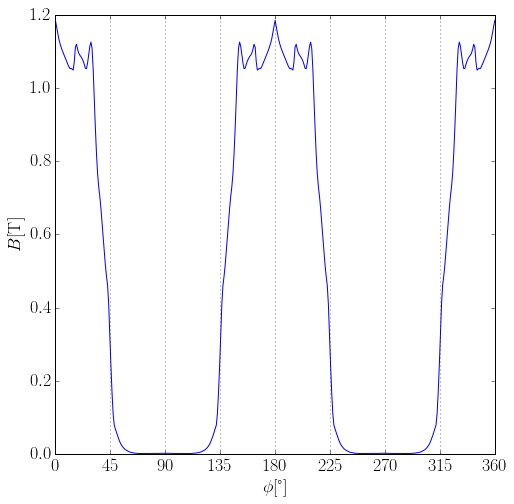

In [47]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')


### Magnet profile - comparison between linear and non-linear iron regions

In [48]:
param_dict_linear_5000 = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "alpha_rem_IV_1": 15,
                "alpha_rem_IV_2": 45,
                "alpha_rem_IV_3": 135,
                "phi_S_IV": 45,
                "n_II": 3,
                "alpha_rem_II_1": 15,
                "alpha_rem_II_2": 30,
                "alpha_rem_II_3": 45,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

param_dict_non_linear = param_dict_linear_5000.copy()
param_dict_non_linear["linear_iron"] = 0

param_dict_linear_1000 = param_dict_linear_5000.copy()
param_dict_linear_1000["mu_r_iron"] = 1e3



In [49]:
run_teslamax_from_params(param_dict_linear_5000,verbose=True)
profile_file_path = Path(MAGNETIC_PROFILE_FILENAME)
profile_data_linear_5000 = np.loadtxt(str(profile_file_path),
                         skiprows=1)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Thu Jan 26 10:44:28 BRST 2017
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 389/390 607/607
           Current Progress:   8 % - Circle 2
Memory: 382/406 596/623
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 384/406 597/623
           Current Progress:   0 % - Circle 1
Memory: 389/406 601/623
           Current Progress:   8 % - Circle 2
Memory: 390/406 602/623
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 391/406 603/623
           Current Progress:   0 % - Cylinder Block - Iron II Wedge 1Q
Memory: 431/432 621/623
           Current Progress:   0 % - Circle 1
Memory: 436/436 621/623
           Current Pr

In [50]:
run_teslamax_from_params(param_dict_linear_1000,verbose=True)

profile_data_linear_1000 = np.loadtxt(str(profile_file_path),
                         skiprows=1)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Thu Jan 26 10:45:04 BRST 2017
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 368/375 591/599
           Current Progress:   8 % - Circle 2
Memory: 392/417 615/643
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 394/417 615/643
           Current Progress:   0 % - Circle 1
Memory: 401/417 622/643
           Current Progress:   8 % - Circle 2
-          Current Progress:  17 % - Difference 1
Memory: 401/417 623/643
---------  Current Progress:  93 % - Resolving domains
Memory: 402/417 623/643
           Current Progress:   0 % - Cylinder Block - Iron II Wedge 1Q
Memory: 417/420 615/643
           Current Progress:   0 % - Circle 1
Memory: 424/425 620/643
           Current Pr

In [51]:
run_teslamax_from_params(param_dict_non_linear,verbose=True)

profile_data_non_linear = np.loadtxt(str(profile_file_path),
                         skiprows=1)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Thu Jan 26 10:45:40 BRST 2017
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 354/361 554/562
           Current Progress:   8 % - Circle 2
Memory: 347/361 546/562
-          Current Progress:  17 % - Difference 1
Memory: 348/361 546/562
---------  Current Progress:  93 % - Resolving domains
Memory: 349/361 547/562
           Current Progress:   0 % - Circle 1
Memory: 354/361 552/562
           Current Progress:   8 % - Circle 2
-          Current Progress:  17 % - Difference 1
Memory: 354/361 553/562
---------  Current Progress:  93 % - Resolving domains
Memory: 355/361 553/562
           Current Progress:   0 % - Cylinder Block - Iron II Wedge 1Q
Memory: 369/372 567/570
           Current Progress:   0 % - Circle 1
Memory: 374/374 568/5

In [52]:
phi_vector_linear_1000 = profile_data_linear_1000[:,0]
B_vector_linear_1000 = profile_data_linear_1000[:,1]

phi_vector_linear_5000 = profile_data_linear_5000[:,0]
B_vector_linear_5000 = profile_data_linear_5000[:,1]

phi_vector_non_linear = profile_data_non_linear[:,0]
B_vector_non_linear = profile_data_non_linear[:,1]

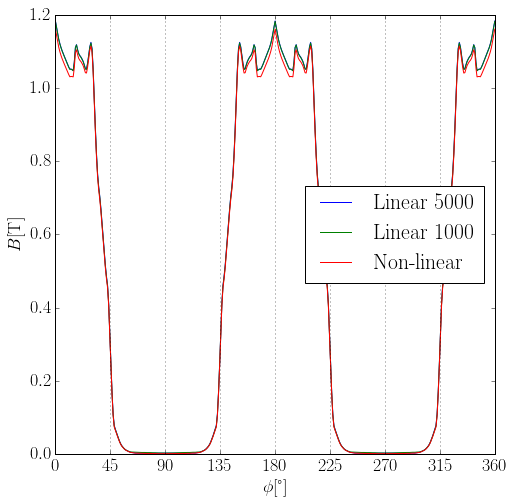

In [53]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

profile_axes.plot(phi_vector_linear_5000,B_vector_linear_5000,label="Linear 5000")
profile_axes.plot(phi_vector_linear_1000,B_vector_linear_1000,label="Linear 1000")
profile_axes.plot(phi_vector_non_linear,B_vector_non_linear,label="Non-linear")

profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')
profile_axes.legend(loc='best')


### Magnet profile - comparison

In [25]:
param_dict_magnet = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.020,
                "R_e": 2,
                "n_IV": 3,
                "alpha_rem_IV_1": 15,
                "alpha_rem_IV_2": 45,
                "alpha_rem_IV_3": 75,
                "phi_S_IV": 45,
                "n_II": 2,
                "alpha_rem_II_1": -45,
                "alpha_rem_II_2": -45,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV": 1.4,
                "mu_r_IV": 1.05,              
             }

param_dict_iron = param_dict_magnet.copy()
param_dict_iron["n_II"] = 0
param_dict_iron["phi_C_II"] = 0
param_dict_iron["phi_S_II"] = 0



In [26]:
run_teslamax_from_params(param_dict_magnet,verbose=True)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Mon Jan 23 11:05:32 BRST 2017
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 414/414 666/666
           Current Progress:   8 % - Circle 2
Memory: 398/414 647/666
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 400/414 648/666
           Current Progress:   0 % - Circle 1
Memory: 403/414 650/666
           Current Progress:   8 % - Circle 2
-          Current Progress:  17 % - Difference 1
Memory: 403/414 651/666
---------  Current Progress:  93 % - Resolving domains
Memory: 404/414 651/666
           Current Progress:   0 % - Cylinder Block - Iron II Wedge 1Q
Memory: 423/423 669/669
           Current Progress:   0 % - Circle 1
Memory: 427/427 672/673
           Current Pr

In [27]:
profile_file_path = Path(MAGNETIC_PROFILE_FILENAME)
profile_data_magnet = np.loadtxt(str(profile_file_path),
                         skiprows=1)

In [28]:
run_teslamax_from_params(param_dict_iron,verbose=True)
profile_data_iron = np.loadtxt(str(profile_file_path),
                         skiprows=1)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Mon Jan 23 11:06:08 BRST 2017
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 368/369 588/589
           Current Progress:   8 % - Circle 2
Memory: 368/387 587/609
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 370/387 588/609
           Current Progress:   0 % - Circle 1
Memory: 375/387 592/609
           Current Progress:   8 % - Circle 2
Memory: 375/387 593/609
-          Current Progress:  17 % - Difference 1
Memory: 376/387 594/609
---------  Current Progress:  93 % - Resolving domains
           Current Progress:   0 % - Cylinder Block - Iron II
Memory: 404/404 606/609
           Current Progress:   0 % - Circle 1
Memory: 409/409 607/609
           Current Progress:  

In [29]:
phi_vector_magnet = profile_data_magnet[:,0]
B_vector_magnet = profile_data_magnet[:,1]

phi_vector_iron = profile_data_iron[:,0]
B_vector_iron = profile_data_iron[:,1]

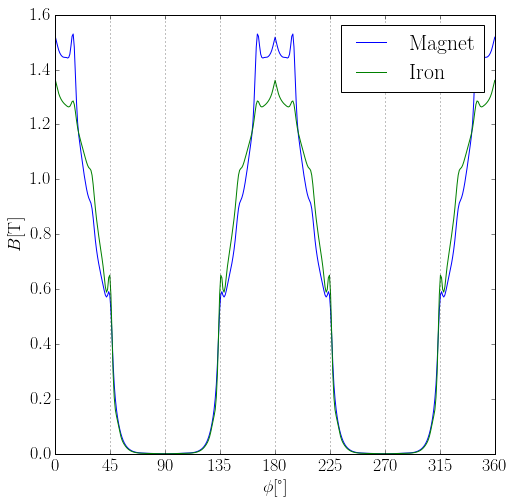

In [30]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

profile_axes.plot(phi_vector_magnet,B_vector_magnet,label="Magnet")
profile_axes.plot(phi_vector_iron,B_vector_iron,label="Iron")
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')
profile_axes.legend(loc='best')


### Influence of the external radius

In this code block, we run simulations for some values of $R\ped{o}$, $h\ped{gap}$ and $R\ped{s}$. The innermost radius is fixed as $R\ped{i} = 15 \mathrm{mm}$. The material properties are fixed. 

We consider two cases:



### Case 1: remanence from the analytical solution

In [88]:
R_i = 15e-3

R_o_values = np.array([40e-3,50e-3,60e-3])

h_gap_values = np.array([20e-3,30e-3])

params_base = {"R_i": R_i,
                "h_fc": 0.020,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "B_rem_IV": 1.4,
                "mu_r_IV": 1.05,
               "n_II": 0, #iron core
               "phi_C_II": 0,
               "phi_S_II": 0
              }

n_R_s_points = 10

R_s_min = 100e-3
R_s_max = 150e-3
R_s_vector = np.linspace(R_s_min,R_s_max,n_R_s_points)

i_sim = 0 #simulation index
teslamax_table = DataFrame()
for R_o in R_o_values:
    
    params_base["R_o"] = R_o

    for h_gap in h_gap_values:
        
        params_base["h_gap"] = h_gap
        
        B_h_vector = np.empty(n_R_s_points)
        B_l_vector = np.empty(n_R_s_points)
        
        i_R_s = 0 #innermost index to build the plot
        for R_s in R_s_vector:
            
            params_base["R_s"] = R_s
            
            # as a reference, we use the analytical model to determine
            # the direction of remanence
            
            # for the outer magnet, it can be shown that, if a point is at an
            # angular position \phi from the horizontal, then the remanence
            # is oriented with an angle 2\phi
            for k in range(0,params_base["n_IV"]):
                phi_segment_IV = (1.0/2 + k) * params_base["phi_S_IV"]/params_base["n_IV"]
                params_base["alpha_rem_IV_%d" %(k+1)] = 2*phi_segment_IV
            
            write_parameter_file_from_dict(params_base)
                        
            run_teslamax()
            
            results = read_main_results_file()
            
            B_high = results["B_high[T]"]
            B_h_vector[i_R_s] = B_high
            
            B_low = results["B_low[T]"]
            B_l_vector[i_R_s] = B_low
            
            parameters = get_comsol_parameters_series()
            
            simulation_row = DataFrame(pd.concat([parameters,results]).to_dict(),index=[i_sim,])
            simulation_row.index.name = "Case"
            simulation_row["n_IV"] = simulation_row["n_IV"].astype('int64')
            i_sim = i_sim + 1
            
            teslamax_table = pd.concat([teslamax_table,simulation_row])
            teslamax_table.to_csv(TESLAMAX_RESULTS_FILENAME,sep=' ')
            
            i_R_s = i_R_s+1

## Case 2: random direction of remanence

In [107]:
360*np.random.random()

187.42015817481317

In [25]:
R_i = 15e-3

R_o_values = np.array([70e-3,80e-3,90e-3])

h_gap_values = np.array([15e-3,25e-3,35e-3])

params_base = {"R_i": R_i,
                "h_fc": 0.020,
                "R_e": 2,
                "n_II": 3,
                "n_IV": 3,
                "phi_S_II": 45,
                "phi_S_IV": 45,
                "B_rem_II": 1.47, #Bakker N52
                "mu_r_II": 1.05,
                "H_c_II": 850e3,
                "B_rem_IV": 1.47,
                "mu_r_IV": 1.05,
                "H_c_IV": 850e3,
              }

n_R_s_points = 10

R_s_min = 140e-3
R_s_max = 200e-3
R_s_vector = np.linspace(R_s_min,R_s_max,n_R_s_points)

i_sim = 0 #simulation index
teslamax_table_random = DataFrame()
for R_o in R_o_values:
    
    params_base["R_o"] = R_o

    for h_gap in h_gap_values:
        
        params_base["h_gap"] = h_gap
        
        B_h_vector = np.empty(n_R_s_points)
        B_l_vector = np.empty(n_R_s_points)
        
        i_R_s = 0 #innermost index to build the plot
        for R_s in R_s_vector:
            
            params_base["R_s"] = R_s
            
            # in this analysis, we set a random direction of remanence
            
            # for the inner magnet, the remanence is always horizontal
            for j in range(0,params_base["n_II"]):
                params_base["alpha_rem_II_%d" %(j+1)] = 360*np.random.random()

            for k in range(0,params_base["n_IV"]):

                params_base["alpha_rem_IV_%d" %(k+1)] = 360*np.random.random()
            
            write_parameter_file_from_dict(params_base)
                        
            run_teslamax()
            
            results = read_main_results_file()
            
            B_high = results["B_high[T]"]
            B_h_vector[i_R_s] = B_high
            
            B_low = results["B_low[T]"]
            B_l_vector[i_R_s] = B_low
            
            parameters = get_comsol_parameters_series()
            
            simulation_row = DataFrame(pd.concat([parameters,results]).to_dict(),index=[i_sim,])
            simulation_row.index.name = "Case"
            simulation_row["n_II"] = simulation_row["n_II"].astype('int64')
            simulation_row["n_IV"] = simulation_row["n_IV"].astype('int64')
            i_sim = i_sim + 1
            
            teslamax_table_random = pd.concat([teslamax_table_random,simulation_row])
            teslamax_table_random.to_csv(TESLAMAX_RESULTS_RANDOM_FILENAME,sep=' ')
            
            i_R_s = i_R_s+1

### Process the results

If desired, load the table from a file, instead of (re-)running the above code block:

In [89]:
teslamax_table = pd.read_table(TESLAMAX_RESULTS_FILENAME,sep=" ",index_col=0)
#teslamax_table_random = pd.read_table(TESLAMAX_RESULTS_RANDOM_FILENAME,sep=" ",index_col=0)

In [90]:
teslamax_table

,-H_Brem_II_max[A/m],-H_Brem_IV_max[A/m],A_gap[m2],A_magnet[m2],B_high[T],B_low[T],B_rem_IV[T],R_c[m],R_e[m],R_g[m],...,alpha_rem_IV_3[deg],delta_phi_S_IV[deg],h_fc[m],h_gap[m],mu_r_IV,n_II,n_IV,phi_C_II[deg],phi_S_II[deg],phi_S_IV[deg]
Case,,,,,,,,,,,,,,,,,,,,,
0,-inf,1.376708e+06,0.006283,0.010053,1.006528,0.085988,1.4,0.120000,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
1,-inf,1.398610e+06,0.006283,0.011847,1.066247,0.090675,1.4,0.125556,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
2,-inf,1.440744e+06,0.006283,0.013738,1.118790,0.094963,1.4,0.131111,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
3,-inf,1.462614e+06,0.006283,0.015725,1.165405,0.098953,1.4,0.136667,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
4,-inf,1.508095e+06,0.006283,0.017810,1.207042,0.102729,1.4,0.142222,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
5,-inf,1.515004e+06,0.006283,0.019992,1.244665,0.106482,1.4,0.147778,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
6,-inf,1.533084e+06,0.006283,0.022270,1.278703,0.110078,1.4,0.153333,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
7,-inf,1.554727e+06,0.006283,0.024646,1.309615,0.113625,1.4,0.158889,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
8,-inf,1.573090e+06,0.006283,0.027119,1.337886,0.117092,1.4,0.164444,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0


Our first filter is to select only values where the low magnetic value is smaller than a "critical value" of $0.1 \mathrm{T}$.

In [91]:
teslamax_table_valid = teslamax_table[teslamax_table["B_low[T]"] < 0.1]
teslamax_table_valid

,-H_Brem_II_max[A/m],-H_Brem_IV_max[A/m],A_gap[m2],A_magnet[m2],B_high[T],B_low[T],B_rem_IV[T],R_c[m],R_e[m],R_g[m],...,alpha_rem_IV_3[deg],delta_phi_S_IV[deg],h_fc[m],h_gap[m],mu_r_IV,n_II,n_IV,phi_C_II[deg],phi_S_II[deg],phi_S_IV[deg]
Case,,,,,,,,,,,,,,,,,,,,,
0,-inf,1.376708e+06,0.006283,0.010053,1.006528,0.085988,1.4,0.120000,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
1,-inf,1.398610e+06,0.006283,0.011847,1.066247,0.090675,1.4,0.125556,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
2,-inf,1.440744e+06,0.006283,0.013738,1.118790,0.094963,1.4,0.131111,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
3,-inf,1.462614e+06,0.006283,0.015725,1.165405,0.098953,1.4,0.136667,2.0,0.06,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
10,-inf,1.360726e+06,0.010367,0.008011,0.715480,0.097336,1.4,0.120000,2.0,0.07,...,75.0,15.0,0.02,0.03,1.05,0.0,3,0.0,0.0,45.0
20,-inf,1.189760e+06,0.007540,0.008011,0.858179,0.057856,1.4,0.120000,2.0,0.07,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
21,-inf,1.231954e+06,0.007540,0.009805,0.934042,0.062145,1.4,0.125556,2.0,0.07,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
22,-inf,1.273828e+06,0.007540,0.011696,0.999901,0.065812,1.4,0.131111,2.0,0.07,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0
23,-inf,1.316339e+06,0.007540,0.013683,1.058144,0.069037,1.4,0.136667,2.0,0.07,...,75.0,15.0,0.02,0.02,1.05,0.0,3,0.0,0.0,45.0


We will create one figure for each value of $R\ped{o}$, with one curve for each value of $h\ped{gap}$; the axes will represent $R\ped{s}$ and $B\ped{h}$.

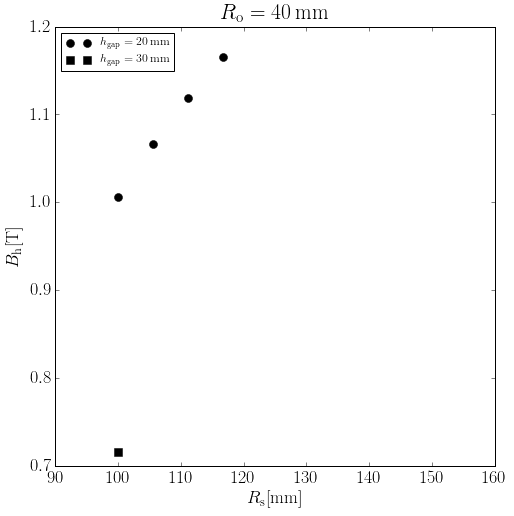

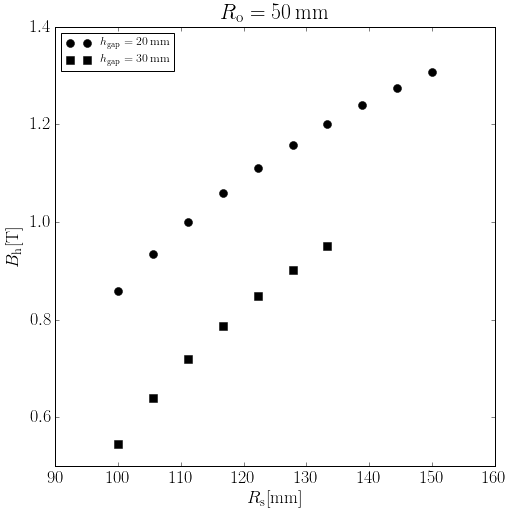

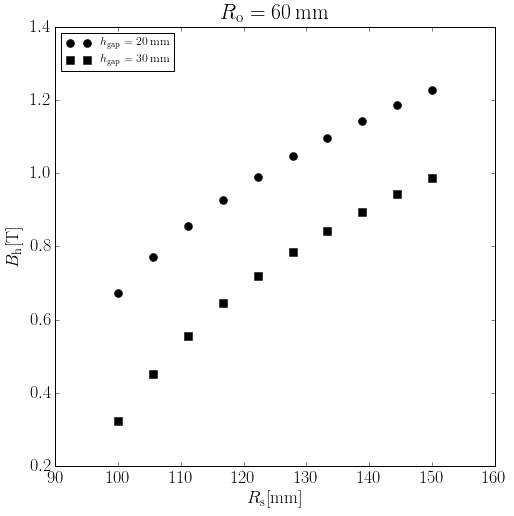

In [92]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)

R_o_values = teslamax_table_valid["R_o[m]"].unique()

markers = ["ko","ks","kv"]

h_gap_values = teslamax_table_valid["h_gap[m]"].unique()

for R_o in R_o_values:

    table_R_o = teslamax_table_valid[teslamax_table_valid["R_o[m]"] == R_o]

    R_o_figure = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
    
    R_o_axes = R_o_figure.add_subplot(111)

    title_text = r"$R\ped{o} = \SI{" + "%.0f" %(1e3*R_o,) + r"}{\milli\meter}$"
    R_o_axes.set_title(title_text)

    R_o_axes.set_xlabel(r"$R\ped{s} [\si{\milli\meter}]$")
    R_o_axes.set_ylabel(r"$B\ped{h} [\si{\tesla}]$")
    R_o_axes.set_xlim((1e3*(R_s_min-10e-3),1e3*(R_s_max+10e-3)))

    i_h = 0
    for h_gap in h_gap_values:

        table_h_gap = table_R_o[table_R_o["h_gap[m]"] == h_gap]

        R_s_values = 1e3*table_h_gap["R_s[m]"]
        B_h_values = table_h_gap["B_high[T]"]

        legend_text = r"$h\ped{gap} = \SI{" + "%.0f" %(1e3*h_gap) + "}{\milli\meter}$"

        R_o_axes.plot(R_s_values,
                      B_h_values,
                      markers[i_h],
                      label=legend_text,
                     markersize=MARKERSIZE)
        i_h = i_h + 1

    R_o_axes.legend(loc="upper left",fontsize=FONTSIZE_SMALL)
    
    fig_path = "Bh_Ro_%.0f" %(1e3*R_o) + PLOT_EXTENSION
    R_o_figure.savefig(fig_path,dpi=DPI,bbox_inches='tight')
    


### Analyzing one particular case

It seems that, for all cases, at least one of the magnets is demagnetized. Surprinsigly, the problem seems to be on magnet IV:

In [21]:
teslamax_table["-H_Brem_II_max[A/m]"] <= 1000e3

Case
0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
Name: -H_Brem_II_max[A/m], dtype: bool

In [22]:
teslamax_table["-H_Brem_IV_max[A/m]"] <= 1000e3

Case
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
Name: -H_Brem_IV_max[A/m], dtype: bool

To investigate even further, we plot the relevant fields for magnet IV, for a case of this table:

In [23]:
table_case = teslamax_table.iloc[0]
table_case

-H_Brem_II_max[A/m]    5.521286e+05
-H_Brem_IV_max[A/m]    1.421567e+06
A_gap[m2]              7.540000e-03
A_magnet[m2]           2.666400e-02
B_high[T]              1.222779e+00
B_low[T]               8.075200e-02
B_rem_II[T]            1.400000e+00
B_rem_IV[T]            1.400000e+00
R_c[m]                 1.600000e-01
R_e[m]                 2.000000e+00
R_g[m]                 7.000000e-02
R_i[m]                 1.500000e-02
R_o[m]                 5.000000e-02
R_s[m]                 1.400000e-01
alpha_rem_II_1[deg]    0.000000e+00
alpha_rem_II_2[deg]    0.000000e+00
alpha_rem_II_3[deg]    0.000000e+00
alpha_rem_IV_1[deg]    1.500000e+01
alpha_rem_IV_2[deg]    4.500000e+01
alpha_rem_IV_3[deg]    7.500000e+01
delta_phi_S_II[deg]    1.500000e+01
delta_phi_S_IV[deg]    1.500000e+01
h_fc[m]                2.000000e-02
h_gap[m]               2.000000e-02
mu_r_II                1.050000e+00
mu_r_IV                1.050000e+00
n_II                   3.000000e+00
n_IV                   3.000

In [24]:
run_teslamax_from_params(table_case,verbose=True)

*******************************************
***COMSOL 5.2.1.229 progress output file***
*******************************************
Thu Nov 03 10:55:07 BRST 2016
COMSOL 5.2a (Build: 229) starting in batch mode
Running: C:\Users\fabiofortkamp\code\teslamax\java\TeslaMax.class
           Current Progress:   0 % - Circle 1
Memory: 373/382 590/601
           Current Progress:   8 % - Circle 2
Memory: 391/412 607/631
-          Current Progress:  17 % - Difference 1
Memory: 391/412 608/631
---------  Current Progress:  93 % - Resolving domains
Memory: 393/412 608/631
           Current Progress:   0 % - Circle 1
Memory: 396/412 612/631
           Current Progress:   8 % - Circle 2
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
           Current Progress:   0 % - Cylinder Block 1 - Magnet II - 1Q
Memory: 442/442 637/637
           Current Progress:   0 % - Circle 1
Memory: 447/447 637/637
           Current Progress:   0 % - Circle 2

In [25]:
def normalize_vector(v):
    """
    Return the normalized (dimensionless) form of vector (or list of vectors) v"""
    
    # v could be a single vector or a list of vectors, so we handle different cases
    if v.ndim == 1:
        return v/np.linalg.norm(v)
    else:
        v_norm = np.linalg.norm(v,axis=1)
        v_norm_inv = np.reciprocal(v_norm).reshape(len(v),1)
        return np.multiply(v,v_norm_inv)

In [34]:
magnet_II_data = read_comsol_data_file(H_II_FILENAME)
x_II, y_II, B_II_x, B_II_y, H_II_x, H_II_y, B_rem_II_x, B_rem_II_y = magnet_II_data.T

H_II = np.array([H_II_x,H_II_y]).T
B_II = np.array([B_II_x,B_II_y]).T
B_rem_II = np.array([B_rem_II_x,B_rem_II_y]).T
B_rem_hat_II = normalize_vector(B_rem_II)
B_rem_hat_II_x, B_rem_hat_II_y = B_rem_hat_II.T

# already using the sign notation for the quadrants
Psi_II = -(H_II_x * B_rem_hat_II_x + H_II_y * B_rem_hat_II_y) * (B_II_x * B_rem_hat_II_x + B_II_y * B_rem_hat_II_y)

magnet_IV_data = read_comsol_data_file(H_IV_FILENAME)
x_IV, y_IV, B_IV_x, B_IV_y, H_IV_x, H_IV_y, B_rem_IV_x, B_rem_IV_y = magnet_IV_data.T

H_IV = np.array([H_IV_x,H_IV_y]).T
B_IV = np.array([B_IV_x,B_IV_y]).T
B_rem_IV = np.array([B_rem_IV_x,B_rem_IV_y]).T
B_rem_hat_IV = normalize_vector(B_rem_IV)
B_rem_hat_IV_x, B_rem_hat_IV_y = B_rem_hat_IV.T

Psi_IV = -(H_IV_x * B_rem_hat_IV_x + H_IV_y * B_rem_hat_IV_y) * (B_IV_x * B_rem_hat_IV_x + B_IV_y * B_rem_hat_IV_y)


In [27]:
def create_quater_circle_figure_template(r_lim,params):
    """
    Return (fig,axes) correspondent to a figure of the first quadrant, limited by r_lim. 
    Both magnets are also drawn.
    
    The size of the figure is controlled by FIGSIZE_INCHES"""
    
    fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
    axes = fig.add_subplot(111,aspect='equal')
    
    axes.set_ylim(0,1e3*r_lim)
    axes.set_xlim(0,1e3*r_lim)

    axes.set_ylabel(r'$r\ [\si{\mm}$]')
    axes.set_xlabel(r'$r\ [\si{\mm}$]')
    
    R_o = params['R_o[m]']
    R_i = params['R_i[m]']
    R_s = params['R_s[m]']
    R_g = params['R_g[m]']
    
    magnet_II_outer=plt.Circle((0,0),1e3*R_o,color='k',fill=False)
    magnet_II_inner=plt.Circle((0,0),1e3*R_i,color='k',fill=False)
    axes.add_artist(magnet_II_outer)
    axes.add_artist(magnet_II_inner)

    magnet_IV_outer=plt.Circle((0,0),1e3*R_s,color='k',fill=False)
    magnet_IV_inner=plt.Circle((0,0),1e3*R_g,color='k',fill=False)
    axes.add_artist(magnet_IV_outer)
    axes.add_artist(magnet_IV_inner)
    
    return fig, axes

In [28]:
def generate_sector_mesh_points(R1,R2,phi1,phi2):
    """
    Return a list of points [X,Y] uniformily distributed in a circle between radii R1 and R2
    and angular positions phi1 and phi2
    
    The number of points is controlled by N_POINTS_PER_AXIS.
    """
    
    phi_min = phi1
    phi_max = phi2
    
    phi_vector = np.linspace(phi_min,phi_max,N_POINTS_PER_AXIS)
    
    r_vector = np.linspace(R1,R2,N_POINTS_PER_AXIS)
    
    phi_grid, r_grid = np.meshgrid(phi_vector,r_vector)
    
    X_vector = (r_grid*np.cos(phi_grid)).flatten()
    Y_vector = (r_grid*np.sin(phi_grid)).flatten()
    
    return np.array([X_vector,Y_vector]).T


    

In [29]:
from matplotlib.patches import Wedge

In [40]:
def create_magnet_IV_figure_template(params):
    """
    Return (fig,axes) correspondent to a figure of the first quadrant of magnet IV. 
    
    
    The size of the figure is controlled by FIGSIZE_INCHES"""
    
    fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
    axes = fig.add_subplot(111,aspect='equal')
    
    R_o = params['R_o[m]']
    R_i = params['R_i[m]']
    R_s = params['R_s[m]']
    R_g = params['R_g[m]']
    R_c = params['R_c[m]']
    r_lim = R_c
    
    axes.set_ylim(0,1e3*r_lim)
    axes.set_xlim(0,1e3*r_lim)

    axes.set_ylabel(r'$r\ [\si{\mm}$]')
    axes.set_xlabel(r'$r\ [\si{\mm}$]')
    
    width_IV = R_s - R_g
    n_IV = int(params['n_IV'])
    delta_phi_S_IV = params['delta_phi_S_IV[deg]']
    for i in range(0,n_IV):
        theta_0 = i*delta_phi_S_IV
        theta_1 = (i+1)*delta_phi_S_IV
        magnet_segment = Wedge((0,0),1e3*R_s,theta_0,theta_1,1e3*width_IV,color='k',fill=False)
        axes.add_artist(magnet_segment)
        
    return fig, axes

def create_magnets_figure_template(params):
    """
    Return (fig,axes) correspondent to a figure of the first quadrant of both magnets. 
    
    
    The size of the figure is controlled by FIGSIZE_INCHES"""
    
    fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
    axes = fig.add_subplot(111,aspect='equal')
    
    R_o = params['R_o[m]']
    R_i = params['R_i[m]']
    R_s = params['R_s[m]']
    R_g = params['R_g[m]']
    R_c = params['R_c[m]']
    r_lim = R_c
    
    axes.set_ylim(0,1e3*r_lim)
    axes.set_xlim(0,1e3*r_lim)

    axes.set_ylabel(r'$r\ [\si{\mm}$]')
    axes.set_xlabel(r'$r\ [\si{\mm}$]')
    
    width_II = R_o - R_i
    n_II = int(params['n_II'])
    delta_phi_S_II = params['delta_phi_S_II[deg]']
    for i in range(0,n_II):
        theta_0 = i*delta_phi_S_II
        theta_1 = (i+1)*delta_phi_S_II
        magnet_segment = Wedge((0,0),1e3*R_o,theta_0,theta_1,1e3*width_II,color='k',fill=False)
        axes.add_artist(magnet_segment)
        
    width_IV = R_s - R_g
    n_IV = int(params['n_IV'])
    delta_phi_S_IV = params['delta_phi_S_IV[deg]']
    for j in range(0,n_IV):
        theta_0 = j*delta_phi_S_IV
        theta_1 = (j+1)*delta_phi_S_IV
        magnet_segment = Wedge((0,0),1e3*R_s,theta_0,theta_1,1e3*width_IV,color='k',fill=False)
        axes.add_artist(magnet_segment)
        
    return fig, axes

In [31]:
from scipy.constants import mu_0

In [32]:
%matplotlib inline

case_series = get_comsol_parameters_series()
r_lim = case_series['R_c[m]']
Hc_fig, Hc_axes = create_magnet_IV_figure_template(case_series)

arrow_scale = 3.0
arrow_width = 0.03
head_axis_length = 3
head_length = 3

n_points = 30
interval = int(len(x_IV)/n_points)
B_rem_IV_vector_field = Hc_axes.quiver(1e3*x_IV[0:-1:interval],
                                      1e3*y_IV[0:-1:interval],
                                      B_rem_IV_x[0:-1:interval],
                                      B_rem_IV_y[0:-1:interval],
                                      units='inches',
                                      pivot='middle',
                                      headlength=head_length,
                                      headaxislength=head_axis_length,
                                      scale_units='inches',
                                      scale=arrow_scale,
                                      width=arrow_width)
H_scale = arrow_scale


H_IV_vector_field = Hc_axes.quiver(1e3*x_IV[0:-1:interval],
                                  1e3*y_IV[0:-1:interval],
                                  mu_0*H_IV_x[0:-1:interval],
                                  mu_0*H_IV_y[0:-1:interval],
                                  units='inches',
                                  pivot='middle',
                                  headlength=head_length,
                                  headaxislength=head_axis_length,
                                  scale_units='inches',
                                  scale=H_scale,
                                  width=arrow_width,
                                  color='r')
if SAVE_FIG_Q: save_and_close_figure(Hc_fig, "Hc")

Plot the energy density:

In [68]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)

R_o = table_case['R_o[m]']
R_i = table_case['R_i[m]']
R_s = table_case['R_s[m]']
R_g = table_case['R_g[m]']


r_II_min = 1.001*R_i
r_II_max = 0.999*R_o

r_IV_min = 1.001*R_g
r_IV_max = 0.999*R_s

phi_II_min = 0.0
phi_II_max = np.deg2rad(table_case['phi_S_II[deg]'])

phi_IV_min = 0.0
phi_IV_max = np.deg2rad(table_case['phi_S_IV[deg]'])

# -----
# GRID INITIALIZATION

positions_II = generate_sector_mesh_points(r_II_min,r_II_max,phi_II_min,phi_II_max)
positions_IV = generate_sector_mesh_points(r_IV_min,r_IV_max,phi_IV_min,phi_IV_max)

X_II_vector, Y_II_vector = 1e3*positions_II.T
X_IV_vector, Y_IV_vector = 1e3*positions_IV.T

points_II_to_evaluate = np.array([X_II_vector,Y_II_vector]).T
points_IV_to_evaluate = np.array([X_IV_vector,Y_IV_vector]).T

# loading COMSOL data
points_II_comsol = 1e3*np.array([x_II,y_II]).T
points_IV_comsol = 1e3*np.array([x_IV,y_IV]).T

Psi_II_comsol = griddata(points_II_comsol,Psi_II,points_II_to_evaluate,method='cubic')
Psi_IV_comsol = griddata(points_IV_comsol,Psi_IV,points_IV_to_evaluate,method='cubic')

Psi_II_masked = ma.masked_less(Psi_II_comsol,0.0)
Psi_IV_masked = ma.masked_less(Psi_IV_comsol,0.0)

cmap = matplotlib.cm.jet
cmap.set_bad('w')

Psi_concat = np.concatenate((Psi_II_comsol,Psi_IV_comsol))
Psi_min = 1e-3*np.min(Psi_concat)
Psi_max = 1e-3*np.max(Psi_concat)
   

# create the axes that represent this domain
Psi_fig, Psi_axes = create_magnets_figure_template(table_case)

# plot the color plot

#pcolormesh deals with 2D arrays, so we reshape our vectors
number_of_points_per_axes = int(math.sqrt(len(X_II_vector)))
mesh_shape = ( number_of_points_per_axes, number_of_points_per_axes)

Psi_II_mesh = Psi_axes.pcolormesh(X_II_vector.reshape(mesh_shape),
                                  Y_II_vector.reshape(mesh_shape),
                                  1e-3*Psi_II_masked.reshape(mesh_shape),
                                  vmin=0,
                                  vmax=Psi_max,
                                 cmap=cmap)

number_of_points_per_axes = int(math.sqrt(len(X_IV_vector)))
mesh_shape = ( number_of_points_per_axes, number_of_points_per_axes)

Psi_IV_mesh = Psi_axes.pcolormesh(X_IV_vector.reshape(mesh_shape),
                                  Y_IV_vector.reshape(mesh_shape),
                                  1e-3*Psi_IV_masked.reshape(mesh_shape),
                                  vmin=0,
                                  vmax=Psi_max,
                                 cmap=cmap)

#annotate the plot
Psi_colorbar = Psi_fig.colorbar(Psi_II_mesh,orientation='horizontal')
Psi_colorbar.set_label(r'$\Psi\ [\si{\kilo\joule\per\meter^3}]$')

if SAVE_FIG_Q: save_and_close_figure(Psi_fig, "Psi")


## Visualizing the distribution of coercivity

In [36]:
coerc_data = teslamax_table_valid[["-H_Brem_II_max[A/m]","-H_Brem_IV_max[A/m]"]]
print(coerc_data)

      -H_Brem_II_max[A/m]  -H_Brem_IV_max[A/m]
Case                                          
0           552128.617006         1.421567e+06
1           535658.076751         1.499579e+06
2           521916.958018         1.534433e+06
5           597006.875177         1.451260e+06
10          587044.355679         1.138943e+06
11          571638.445077         1.218939e+06
12          558654.722778         1.289545e+06
13          547586.507687         1.345246e+06
14          538041.407169         1.399054e+06
15          749755.053620         1.161586e+06
16          627395.845214         1.206579e+06
17          587093.324783         1.281676e+06
18          575677.110248         1.374795e+06
19          565864.369646         1.435916e+06
20          794161.288602         1.037812e+06
21          659702.053670         1.096284e+06
22          583368.567886         1.155194e+06
23          572848.586747         1.197887e+06
24          563673.437333         1.263399e+06
25          9

In [45]:
# values of coercivity for Bakker classes with B_rem > 1.4

bakker_coerc_data = 1e3*np.array([955,
                                 875,
                                 1114,
                                 1080,
                                 1353,
                                 ])

We want to visualize all the values of the maximum reverse magnetic field, and compare with Bakker data:

In [86]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)

coerc_hist_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
coerc_hist_axes = coerc_hist_fig.add_subplot(111)

coerc_hist_axes.hist([1e-3*coerc_data.values.T[0],
                      1e-3*coerc_data.values.T[1],
                      1e-3*bakker_coerc_data.T],
                    label=["Magnet II","Magnet IV","Bakker Data"])
coerc_hist_axes.set_title(r'$-\nvh\cdot\nvbremhat[\si{\kilo\ampere\per\meter}]$')
coerc_hist_axes.legend()

if SAVE_FIG_Q: save_and_close_figure(coerc_hist_fig, "coercivity_histogram")

We can see that there are a range of parameters that produce values of reverse magnetic field smaller than some NdFeB classes. In other words, it should be possible to select a magnetic material with a high enough value of intrinsic coercivity.